In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tempfile import NamedTemporaryFile
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Ellipse
from PIL import Image
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter
from skimage import img_as_float
from skimage.transform import rotate, rescale
from skimage.measure import compare_ssim as ssim
import astropy.units as u
from gzbuilderspirals import deprojecting as dpj
from gzbuilderspirals import getDrawnArms, deprojectArm, rThetaFromXY, xyFromRTheta
from gzbuilderspirals.galaxySpirals import GalaxySpirals
import sdssCutoutGrab as scg
import createSubjectsFunctions as csf

In [3]:
nsa = fits.open('../../subjectUpload/nsa_v1_0_1.fits')

In [4]:
nsa_keys = [
    'NSAID', 'ISDSS', 'INED', 'RA', 'DEC', 'Z', 'SERSIC_BA', 'SERSIC_PHI', 'PETRO_THETA', 
    'IAUNAME', 'ZDIST', 'RUN', 'CAMCOL', 'FIELD', 'RERUN',
]
nsaRas = nsa[1].data['ra']
nsaDecs = nsa[1].data['dec']

df_nsa = pd.DataFrame(
    {key: nsa[1].data[key].byteswap().newbyteorder() for key in nsa_keys}
)

In [5]:
classifications = pd.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pd.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

In [6]:
montages = [f for f in os.listdir('montageOutputs') if not f[0] == '.']
montageCoordinates = np.array([
    [float(j) for j in i.replace('+', ' ').split(' ')]
    if '+' in i
    else [float(j) for j in i.replace('-', ' -').split(' ')]
    for i in [f for f in os.listdir('montageOutputs') if not f[0] == '.']
])

In [143]:
subjectId = 21096787

In [144]:
meta = eval(subjects[subjects['subject_id'] == subjectId].iloc[0]['metadata'])

In [145]:
try:
    gal = df_nsa[df_nsa['NSAID'] == int(meta['NSA id'])]
except KeyError:
    gal = {}
    raise KeyError('Metadata does not contain valid NSA id (probably an older galaxy)')
    
gal

,CAMCOL,DEC,FIELD,IAUNAME,INED,ISDSS,NSAID,PETRO_THETA,RA,RERUN,RUN,SERSIC_BA,SERSIC_PHI,Z,ZDIST
455834,5,27.891552,252,J124444.20+275329.5,123633,487276,481907,17.799644,191.184264,301,5087,0.688786,103.175934,0.021077,0.021077


In [146]:
getUrl = lambda id: eval(subjects[subjects['subject_id'] == id]['locations'].iloc[0])['1']
url = getUrl(subjectId)
print('URL of galaxy image:')
print(url)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)
picArray = np.array(pic).astype(float)

URL of galaxy image:
https://panoptes-uploads.zooniverse.org/production/subject_location/b52c16b0-dae3-464b-bfb6-b50bf6c97560.png


In [147]:
montagesDistanceMask = np.add.reduce(
    (montageCoordinates - [gal['RA'].iloc[0], gal['DEC'].iloc[0]])**2,
    axis=1
) < 0.01
usingMontage = np.any(montagesDistanceMask)

In [148]:
if usingMontage:
    montageFolder = montages[
        np.where(montagesDistanceMask)[0][0]
    ]
    fitsName = '{}/{}/{}'.format(
        os.path.abspath('montageOutputs'),
        montageFolder,
        'mosaic.fits'
    )
    print('\t- USING MONTAGED IMAGE')
else:
    fitsName = 'fitsImages/{0}/{1}/frame-r-{0:06d}-{1}-{2:04d}.fits'.format(
        int(gal['RUN']),
        int(gal['CAMCOL']),
        int(gal['FIELD'])
    )
print(fitsName)

fitsImages/5087/5/frame-r-005087-5-0252.fits


In [149]:
from astropy.wcs import WCS
wFits = WCS(fitsName)
# edit to center on the galaxy
wFits.wcs.crval = [float(gal['RA']), float(gal['DEC'])]
wFits.wcs.crpix = [256, 256]
try:
    fits_cdelt = wFits.wcs.cdelt
except AttributeError:
    fits_cdelt = [0.396 / 3600]*2

scale = 4 * (float(gal['PETRO_THETA']) / 3600) / 512
    
wFits.wcs.cdelt = wFits.wcs.cdelt / np.abs(wFits.wcs.cdelt) * scale

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/tlingard/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: cdelt will be ignored since cd is present
  import sys
/Users/tlingard/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: cdelt will be ignored since cd is present
  del sys.path[0]


In [153]:
r = 4 * float(gal['PETRO_THETA']) / 3600
ba = float(gal['SERSIC_BA'])
phi = float(gal['SERSIC_PHI'])
# phi = 0
print('Sersic phi:', phi)

Sersic phi: 103.17593383789062


In [159]:
centerPix, decLine = np.array(wFits.all_world2pix(
    [gal['RA'].iloc[0], gal['RA'].iloc[0]],
    [gal['DEC'].iloc[0], gal['DEC'].iloc[0] + r],
    0
)).T
print(centerPix, decLine)
rot = dpj.getRotationMatrix(np.deg2rad(phi))
print('rotation matrix:')
print(rot)
vec = np.dot(rot, decLine - centerPix)
galaxyAxis = vec + centerPix
rotationAngle = np.rad2deg(np.arctan2(vec[1], vec[0])) - 90
print('Galaxy rotation:', rotationAngle)
print(dpj.getAngle(gal, fitsName))

[255. 255.] [434.50313135 246.10177004]
rotation matrix:
[[-0.22794191396472577, -0.9736747320630733], [0.9736747320630733, -0.22794191396472577]]
Galaxy rotation: 10.338022181216303
10.338022181216303


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/tlingard/PhD/gzbuilderspirals/gzbuilderspirals/deprojecting.py:81: RuntimeWarning: cdelt will be ignored since cd is present
  fits_cdelt = wFits.wcs.cdelt
/Users/tlingard/PhD/gzbuilderspirals/gzbuilderspirals/deprojecting.py:87: RuntimeWarning: cdelt will be ignored since cd is present
  wFits.wcs.cdelt = wFits.wcs.cdelt / np.abs(wFits.wcs.cdelt) * scale


done


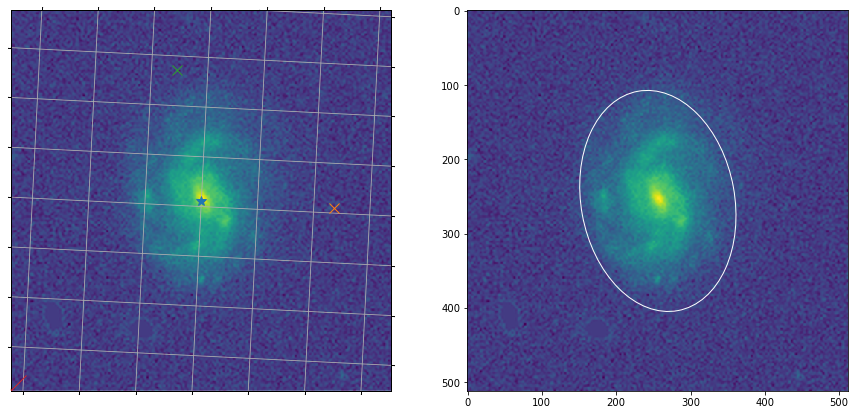

In [158]:
plt.figure(figsize=(15, 10))
plt.subplot(121, projection=wFits)
# plt.subplot(121)
plt.xlabel('RA')
plt.ylabel('Dec')

plt.plot([centerPix[0]], [centerPix[1]], '*', markersize=10)
plt.plot([decLine[0]], [decLine[1]], 'x', markersize=10)
plt.plot([galaxyAxis[0]], [galaxyAxis[1]], 'x', markersize=10)

plt.plot([0], [0], 'x', markersize=30)
plt.imshow(pic)
try:
    ra = plt.gca().coords['ra']
    dec = plt.gca().coords['dec']

    ra.set_major_formatter('d.dd')
    dec.set_major_formatter('d.dd')

    ra.set_ticks(spacing=30 * u.arcsec)
    dec.set_ticks(spacing=30 * u.arcsec)
except AttributeError:
    pass

plt.grid()


plt.subplot(122)
originalIsophote = Ellipse(
    xy=np.array(picArray.shape) / 2,
    width=300,
    height=300 * gal['SERSIC_BA'].iloc[0],
    angle=90 - rotationAngle,
    ec='w',
    fc='none'
)

plt.gca().add_artist(originalIsophote)

plt.imshow(pic)
print('done')